In [97]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import Series
import glob
from datetime import datetime
%matplotlib inline

In [98]:
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 12
lag_exp=24

In [99]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [100]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [101]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [102]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [103]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [104]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [105]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [106]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [107]:
series = pd.read_csv('T1.csv',index_col="Date/Time")
series.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [108]:
del series['LV ActivePower (kW)']
del series['Wind Speed (m/s)']
del series['Wind Direction (°)']
series.head()

,Theoretical_Power_Curve (KWh)
Date/Time,
01 01 2018 00:00,416.328908
01 01 2018 00:10,519.917511
01 01 2018 00:20,390.900016
01 01 2018 00:30,516.127569
01 01 2018 00:40,491.702972


In [109]:

for i in range(0,12):
  series = series[:-1]
series.tail()

,Theoretical_Power_Curve (KWh)
Date/Time,
31 12 2018 21:10,1827.149165
31 12 2018 21:20,2543.911219
31 12 2018 21:30,1811.263260
31 12 2018 21:40,1787.100338
31 12 2018 21:50,2777.504103


In [67]:
raw_values = series.values
diff_values = difference(raw_values, 1)

In [70]:
from pandas import concat
from pandas import datetime
from pandas import DataFrame

In [71]:
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [73]:
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [74]:
scaler, train_scaled, test_scaled = scale(train, test)

In [75]:
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
50505/50505 [==============================] - 235s 5ms/step - loss: 0.0057
Epoch 1/1
50505/50505 [==============================] - 248s 5ms/step - loss: 0.0056
Epoch 1/1
50505/50505 [==============================] - 240s 5ms/step - loss: 0.0056
Epoch 1/1
50505/50505 [==============================] - 242s 5ms/step - loss: 0.0056
Epoch 1/1
50505/50505 [==============================] - 200s 4ms/step - loss: 0.0056
Epoch 1/1
50505/50505 [==============================] - 231s 5ms/step - loss: 0.0056
Epoch 1/1
50505/50505 [==============================] - 241s 5ms/step - loss: 0.0056


In [76]:
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    test_pred = [yhat] + test_pred 
    if i+1<len(test_scaled):
        test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=1683.587644, Expected=1936.655737
Hour=2, Predicted=1828.191637, Expected=1608.743387
Hour=3, Predicted=1527.349602, Expected=1251.008410
Hour=4, Predicted=1220.187394, Expected=1254.728650
Hour=5, Predicted=1249.531732, Expected=1376.495123
Hour=6, Predicted=1420.923702, Expected=2135.288428
Hour=7, Predicted=2117.961242, Expected=2601.071371
Hour=8, Predicted=2593.142584, Expected=1827.149165
Hour=9, Predicted=1840.909159, Expected=2543.911219
Hour=10, Predicted=2542.191660, Expected=1811.263260
Hour=11, Predicted=1800.505915, Expected=1787.100338
Hour=12, Predicted=1783.739907, Expected=2777.504103


In [77]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ",(np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Absolute Percent Error:  21.60369358161079


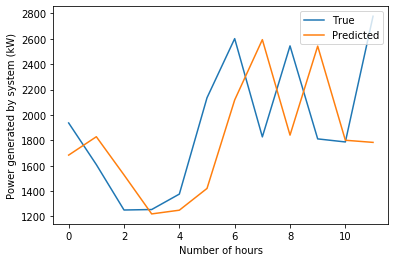

In [78]:
pyplot.plot(raw_values[-predict_values_exp:], label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()

In [83]:
lstm_model.save('wind.h5')